In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [2]:
random.seed(1337)
np.random.seed(1337)
tf.random.set_seed(1337)

with ZipFile("archive.zip","r") as zip:
	zip.extractall()

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	"TB_Chest_Radiography_Database",
	validation_split = 0.2,
	subset = "training",
	seed = 1337,
	shuffle = True,
	image_size = IMG_SIZE,
	batch_size = BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	"TB_Chest_Radiography_Database",
	validation_split = 0.2,
	subset = "validation",
	seed = 1337,
	shuffle = True,
	image_size = IMG_SIZE,
	batch_size = BATCH_SIZE,
)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


['Normal', 'Tuberculosis']


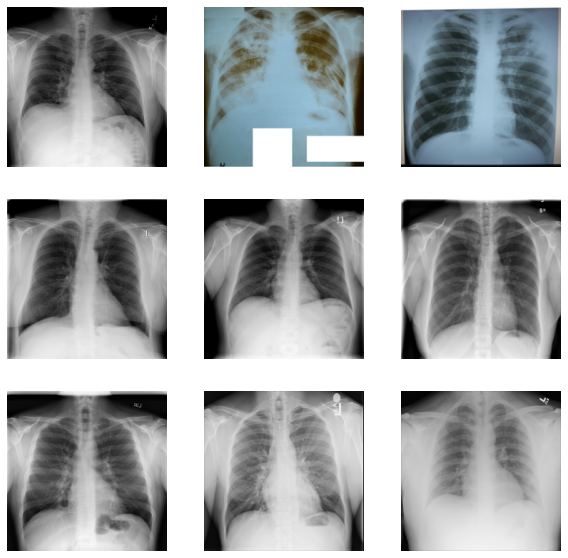

In [4]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
	for i in range(9):
		ax = plt.subplot(3,3,i+1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
	tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

### Showing example

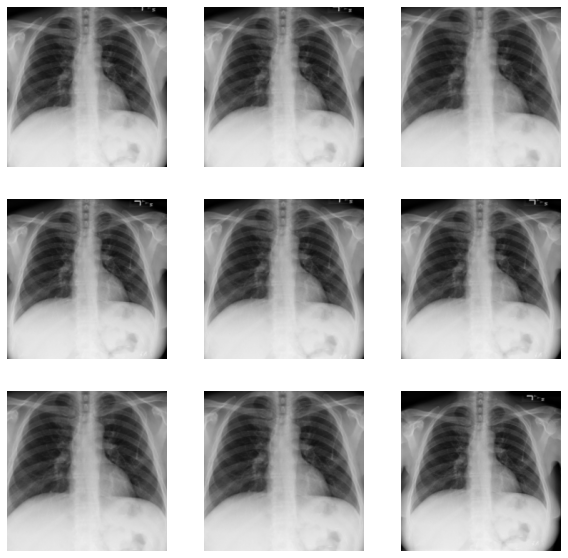

In [7]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
	for i in range(9):
		ax = plt.subplot(3,3,i+1)
		augmented_images = data_augmentation(images)
		plt.imshow(augmented_images[0].numpy().astype("uint8"))
		plt.axis("off")

### Build the model

In [8]:
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input, Model

preprocess_input = resnet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE+(3,)
base_model = ResNet50V2(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")
image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()
feature_batch_average = GlobalAveragePooling2D()(feature_batch)

prediction_layer = Dense(2,activation="sigmoid")
prediction_batch = prediction_layer(feature_batch_average)

class Transfer_ResNet():
	def model(self,y):
		self.x = data_augmentation(y)
		self.x = preprocess_input(self.x)
		self.x = base_model(self.x,training=False)
		self.x = GlobalAveragePooling2D()(self.x)
		self.x = Dropout(0.2,seed=1337)(self.x)
		self.outputs = prediction_layer(self.x)
		self.model = Model(y,self.outputs)
		return self.model

m = Transfer_ResNet()
model = m.model(tf.keras.Input(shape=IMG_SHAPE))
model.summary()
model.compile(Adam(),SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

### Train and the model on test dataset

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

if __name__=="__main__":
	loss0,accuracy0 = model.evaluate(val_ds)
	print("Initial loss: {:.2f} %".format(100*loss0))
	print("Initial accuracy: {:.2f} %".format(100*accuracy0))
	checkpoint = ModelCheckpoint("tuberculosis.hdf5",save_weights_only=False,monitor="val_loss",save_best_only=True)
	model.fit(train_ds,epochs=7,validation_data=val_ds,callbacks=[checkpoint])
	best = load_model("tuberculosis.hdf5")
	loss,accuracy = best.evaluate(test_ds)
	print("\nTest accuracy: {:.2f} %".format(100*accuracy))
	print("Test loss : {:.2f} %".format(100*loss))

22/22 [==============================] - 7s 190ms/step - loss: 1.7343 - accuracy: 0.1824
Initial loss: 173.43 %
Initial accuracy: 18.24 %
Epoch 1/7
105/105 [==============================] - 22s 184ms/step - loss: 0.2728 - accuracy: 0.9012 - val_loss: 0.1243 - val_accuracy: 0.9529


/home/maverick/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/7
105/105 [==============================] - 20s 185ms/step - loss: 0.1326 - accuracy: 0.9524 - val_loss: 0.0721 - val_accuracy: 0.9765
Epoch 3/7
105/105 [==============================] - 21s 196ms/step - loss: 0.1003 - accuracy: 0.9625 - val_loss: 0.0799 - val_accuracy: 0.9662
Epoch 4/7
105/105 [==============================] - 21s 198ms/step - loss: 0.0861 - accuracy: 0.9679 - val_loss: 0.0673 - val_accuracy: 0.9838
Epoch 5/7
105/105 [==============================] - 21s 201ms/step - loss: 0.0747 - accuracy: 0.9717 - val_loss: 0.0560 - val_accuracy: 0.9838
Epoch 6/7
105/105 [==============================] - 21s 200ms/step - loss: 0.0769 - accuracy: 0.9729 - val_loss: 0.0606 - val_accuracy: 0.9853
Epoch 7/7
5/5 [==============================] - 2s 152ms/step - loss: 0.0564 - accuracy: 0.9937

Test accuracy: 99.37 %
Test loss : 5.64 %
